<a href="https://colab.research.google.com/github/allanbraquiel/Stack-Labs/blob/main/Stack_Labs_Previs%C3%A3o_de_vendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack Labs - Scikit-Learn Squad

# Participantes:
- Allan
- Norberto
- Fabricio

# Finalidade do projeto
- Realizar uma previsão de vendas de datas futuras

# Esquema de dados:

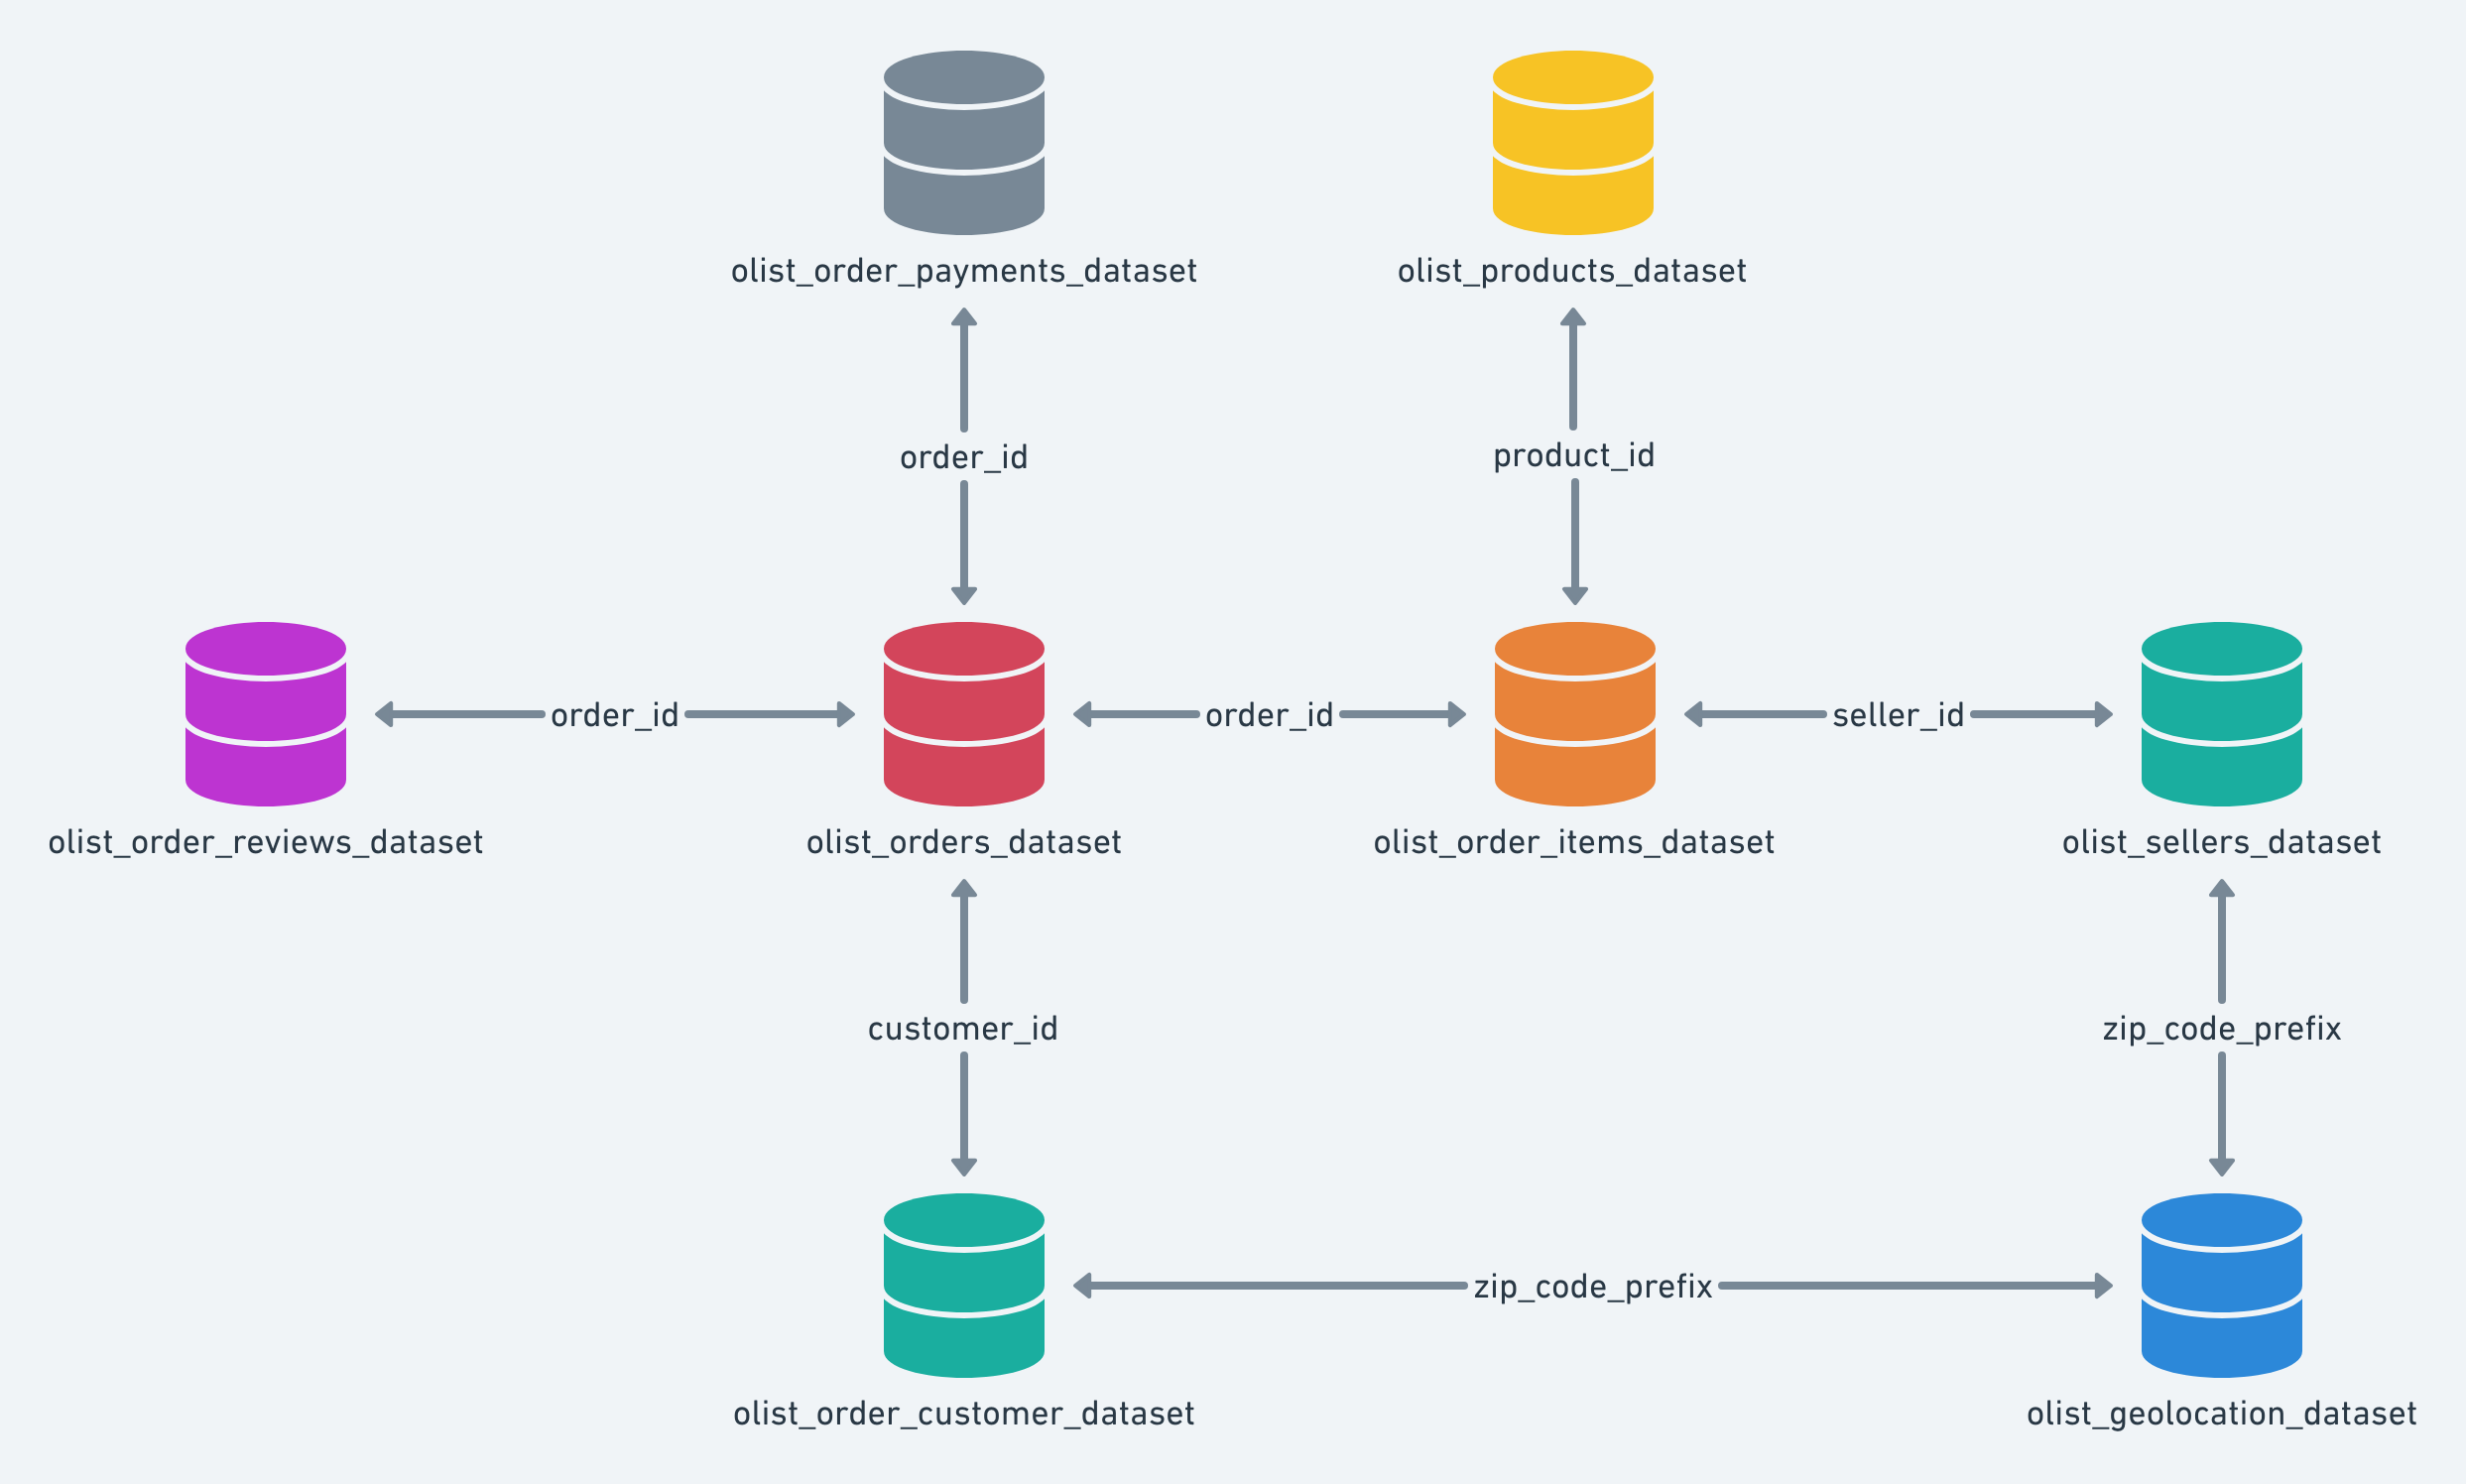

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime, timedelta
from pandas import DataFrame
from functools import reduce

# aumentando o tamanho da figura
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

# Carregando os datasets

In [4]:
df_customers = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Stack Labs/archive/olist_customers_dataset.csv", sep=",")
df_geolocation = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Stack Labs/archive/olist_geolocation_dataset.csv", sep=",")
df_order_items = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Stack Labs/archive/olist_order_items_dataset.csv", sep=",", 
                             parse_dates=["shipping_limit_date"])

df_order_payments = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Stack Labs/archive/olist_order_payments_dataset.csv", sep=",")
df_order_reviews = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Stack Labs/archive/olist_order_reviews_dataset.csv", sep=",", 
                               parse_dates=[["review_creation_date", "review_answer_timestamp"]])

df_orders = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Stack Labs/archive/olist_orders_dataset.csv", sep=",", 
                        parse_dates=["order_purchase_timestamp", 
                                     "order_approved_at", 
                                     "order_delivered_carrier_date", 
                                     "order_delivered_customer_date", 
                                     "order_estimated_delivery_date"])

df_products = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Stack Labs/archive/olist_products_dataset.csv", sep=",")
df_sellers = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Stack Labs/archive/olist_sellers_dataset.csv", sep=",")
df_product_category = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Stack Labs/archive/product_category_name_translation.csv", sep=",")

# Visão geral dos datasets

## Conjunto de dados de clientes

Este conjunto de dados contém informações sobre o cliente e sua localização. Use-o para identificar clientes únicos no conjunto de dados de pedidos e para encontrar o local de entrega dos pedidos.

Em nosso sistema, cada pedido é atribuído a um ID de cliente único. Isso significa que o mesmo cliente obterá IDs diferentes para pedidos diferentes. O objetivo de ter um customer unique_id no conjunto de dados é permitir que você identifique os clientes que fizeram recompras na loja. Caso contrário, você descobrirá que cada pedido tem um cliente diferente associado.

Colunas:
- **customer_id** - chave para o conjunto de dados de pedidos. Cada pedido possui um customer_id exclusivo.
- **customer_unique_id** - identificador único de um cliente.
- **customer_zip_code_prefix** - primeiros cinco dígitos do código postal do cliente
- **customer_city** - nome da cidade do cliente
- **customer_state** - estado do cliente

In [5]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


## Conjunto de dados de geolocalização

Este conjunto de dados contém informações dos CEPs brasileiros e suas coordenadas lat / lng. Use-o para traçar mapas e encontrar distâncias entre vendedores e clientes.

Colunas:

- **geolocation_zip_code_prefix** - primeiros 5 dígitos do código postal
- **geolocation_lat** - latitude
- **geolocation_lng** - longitude
- **geolocation_city** - Nome da Cidade
- **geolocation_state** - Estado

In [7]:
df_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


## Conjunto de dados de itens do pedido

Este conjunto de dados inclui dados sobre os itens adquiridos em cada pedido.

Colunas:
- **order_id** - identificador único do pedido
- **order_item_id** - número sequencial que identifica o número de itens incluídos na mesma ordem.
- **product_id** - identificador único do produto
- **seller_id** - identificador único do vendedor
- **shipping_limit_date** - Mostra a data limite de envio do vendedor para lidar com o pedido ao parceiro logístico.
- **price** - Preço do item
- **freight_value** - item com valor de frete (se um pedido tiver mais de um item, o valor do frete é dividido entre os itens

In [8]:
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [9]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


## Conjunto de dados de pagamentos

Este conjunto de dados inclui dados sobre as opções de pagamento de pedidos.

Colunas:
- **order_id** - identificador exclusivo de um pedido.
- **payment_sequential** - um cliente pode pagar um pedido com mais de um método de pagamento. Se ele fizer isso, uma sequência será criada
- **payment_type** - método de pagamento escolhido pelo cliente.
- **payment_installments** - número de parcelas escolhido pelo cliente.
- **payment_value** - valor da transação.

In [10]:
df_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [11]:
df_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [12]:
df_order_payments.payment_type.value_counts(normalize=True)

credit_card    0.739224
boleto         0.190440
voucher        0.055590
debit_card     0.014718
not_defined    0.000029
Name: payment_type, dtype: float64

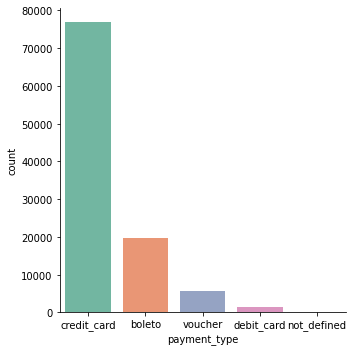

In [13]:
lista = list(df_order_payments.payment_type.value_counts().keys())
sns.catplot(x="payment_type", kind="count", palette="Set2", data=df_order_payments, order=lista)

In [14]:
# soma de todos os valores do pedido
df_order_payments.groupby("order_id")["payment_value"].sum().head(20)

order_id
00010242fe8c5a6d1ba2dd792cb16214     72.19
00018f77f2f0320c557190d7a144bdd3    259.83
000229ec398224ef6ca0657da4fc703e    216.87
00024acbcdf0a6daa1e931b038114c75     25.78
00042b26cf59d7ce69dfabb4e55b4fd9    218.04
00048cc3ae777c65dbb7d2a0634bc1ea     34.59
00054e8431b9d7675808bcb819fb4a32     31.75
000576fe39319847cbb9d288c5617fa6    880.75
0005a1a1728c9d785b8e2b08b904576c    157.60
0005f50442cb953dcd1d21e1fb923495     65.39
00061f2a7bc09da83e415a52dc8a4af1     68.87
00063b381e2406b52ad429470734ebd5     57.98
0006ec9db01a64e59a68b2c340bf65a7     97.32
0008288aa423d2a3f00fcb17cd7d8719    126.54
0009792311464db532ff765bf7b182ae    127.55
0009c9a17f916a706d71784483a5d643    650.34
000aed2e25dbad2f9ddb70584c5a2ded    152.77
000c3e6612759851cc3cbb4b83257986    112.71
000e562887b1f2006d75e0be9558292e     41.11
000e63d38ae8c00bbcb5a30573b99628     56.78
Name: payment_value, dtype: float64

In [15]:
df_order_payments.loc[df_order_payments["order_id"] == 'e481f51cbdc54678b7cc49136f2d6af7']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
10770,e481f51cbdc54678b7cc49136f2d6af7,1,credit_card,1,18.12
44246,e481f51cbdc54678b7cc49136f2d6af7,3,voucher,1,2.00
91130,e481f51cbdc54678b7cc49136f2d6af7,2,voucher,1,18.59


In [16]:
# Criando um dataset somente com o id do pedido e o total
df_total_pedido = pd.DataFrame(df_order_payments.groupby("order_id")["payment_value"].sum())

In [17]:
df_total_pedido.reset_index()

,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,343.40
99436,fffcd46ef2263f404302a634eb57f7eb,386.53
99437,fffce4705a9662cd70adb13d4a31832d,116.85
99438,fffe18544ffabc95dfada21779c9644f,64.71


## Conjunto de dados de avaliações de pedidos

Este conjunto de dados inclui dados sobre as avaliações feitas pelos clientes.

Depois que um cliente compra o produto na Olist Store, um vendedor é notificado para atender a esse pedido. Assim que o cliente recebe o produto, ou quando vence a previsão de entrega, o cliente recebe por e-mail uma pesquisa de satisfação onde pode dar um apontamento sobre a experiência de compra e anotar alguns comentários.

Colunas:
- **review_id** - identificador de avaliação exclusivo
- **order_id** - identificador de pedido único
- **review_score** - Nota de 1 a 5 dada pelo cliente em pesquisa de satisfação.
- **review_comment_title** - Título do comentário a partir da avaliação deixada pelo cliente, em português.
- **review_comment_message** - Mensagem de comentário a partir da avaliação deixada pelo cliente, em português.
- **review_creation_date** - Mostra a data em que a pesquisa de satisfação foi enviada ao cliente.
- **review_answer_timestamp** - Mostra o carimbo de data / hora da resposta da pesquisa de satisfação.

In [18]:
df_order_reviews.head()

,review_creation_date_review_answer_timestamp,review_id,order_id,review_score,review_comment_title,review_comment_message
0,2018-01-18 00:00:00 2018-01-18 21:46:59,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN
1,2018-03-10 00:00:00 2018-03-11 03:05:13,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN
2,2018-02-17 00:00:00 2018-02-18 14:36:24,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN
3,2017-04-21 00:00:00 2017-04-21 22:02:06,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.
4,2018-03-01 00:00:00 2018-03-02 10:26:53,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...


## Conjunto de dados do pedido

Este é o conjunto de dados principal. Em cada pedido, você pode encontrar todas as outras informações.

Colunas:
- **order_id** - identificador único do pedido.
- **customer_id** - chave para o conjunto de dados do cliente. Cada pedido possui um customer_id exclusivo.
- **order_status** - Referência ao status do pedido (entregue, enviado, etc).
- **order_purchase_timestamp** - Mostra o carimbo de data / hora da compra.
- **order_approved_at** - Mostra o carimbo de data / hora de aprovação do pagamento.
- **order_delivered_carrier_date** - Mostra a data e hora de postagem do pedido. Quando foi entregue ao parceiro logístico.
- **order_delivered_customer_date** - Mostra a data real de entrega do pedido ao cliente.
- **order_estimated_delivery_date** - Mostra a estimativa da data de entrega que foi informada ao cliente no momento da compra.

In [19]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [20]:
# Criando novas colunas de ano, mês, dia, dia da semana e hora
df_orders['data_pedido'] = df_orders['order_purchase_timestamp'].dt.strftime('%Y-%m-%d')
df_orders['year'] = df_orders['order_purchase_timestamp'].dt.year
df_orders['month'] = df_orders['order_purchase_timestamp'].dt.month
df_orders['day'] = df_orders['order_purchase_timestamp'].dt.day
df_orders['dayofweek'] = df_orders['order_purchase_timestamp'].dt.dayofweek
df_orders['hour'] = df_orders['order_purchase_timestamp'].dt.hour
df_orders['year_month'] = df_orders['order_purchase_timestamp'].dt.to_period('M').astype(str)

df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,data_pedido,year,month,day,dayofweek,hour,year_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-02,2017,10,2,0,10,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07-24,2018,7,24,1,20,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08-08,2018,8,8,2,8,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11-18,2017,11,18,5,19,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02-13,2018,2,13,1,21,2018-02


In [21]:
df_orders.order_status.value_counts(normalize=True)

delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64

## Conjunto de dados de produtos
Este conjunto de dados inclui dados sobre os produtos vendidos pela Olist.

Colunas:
- **product_id** - identificador único de produto
- **product_category_name** - categoria raiz do produto, em português.
- **product_name_lenght** - número de caracteres extraídos do nome do produto.
- **product_description_lenght** - número de caracteres extraídos da descrição do produto.
- **product_photos_qty** - número de fotos publicadas do produto
- **product_weight_g** - peso do produto medido em gramas.
- **product_length_cm** - comprimento do produto medido em centímetros.
- **product_height_cm** - altura do produto medida em centímetros.
- **product_width_cm** - largura do produto medida em centímetros.

In [22]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [23]:
df_products.product_category_name.value_counts().head(10)

cama_mesa_banho           3029
esporte_lazer             2867
moveis_decoracao          2657
beleza_saude              2444
utilidades_domesticas     2335
automotivo                1900
informatica_acessorios    1639
brinquedos                1411
relogios_presentes        1329
telefonia                 1134
Name: product_category_name, dtype: int64

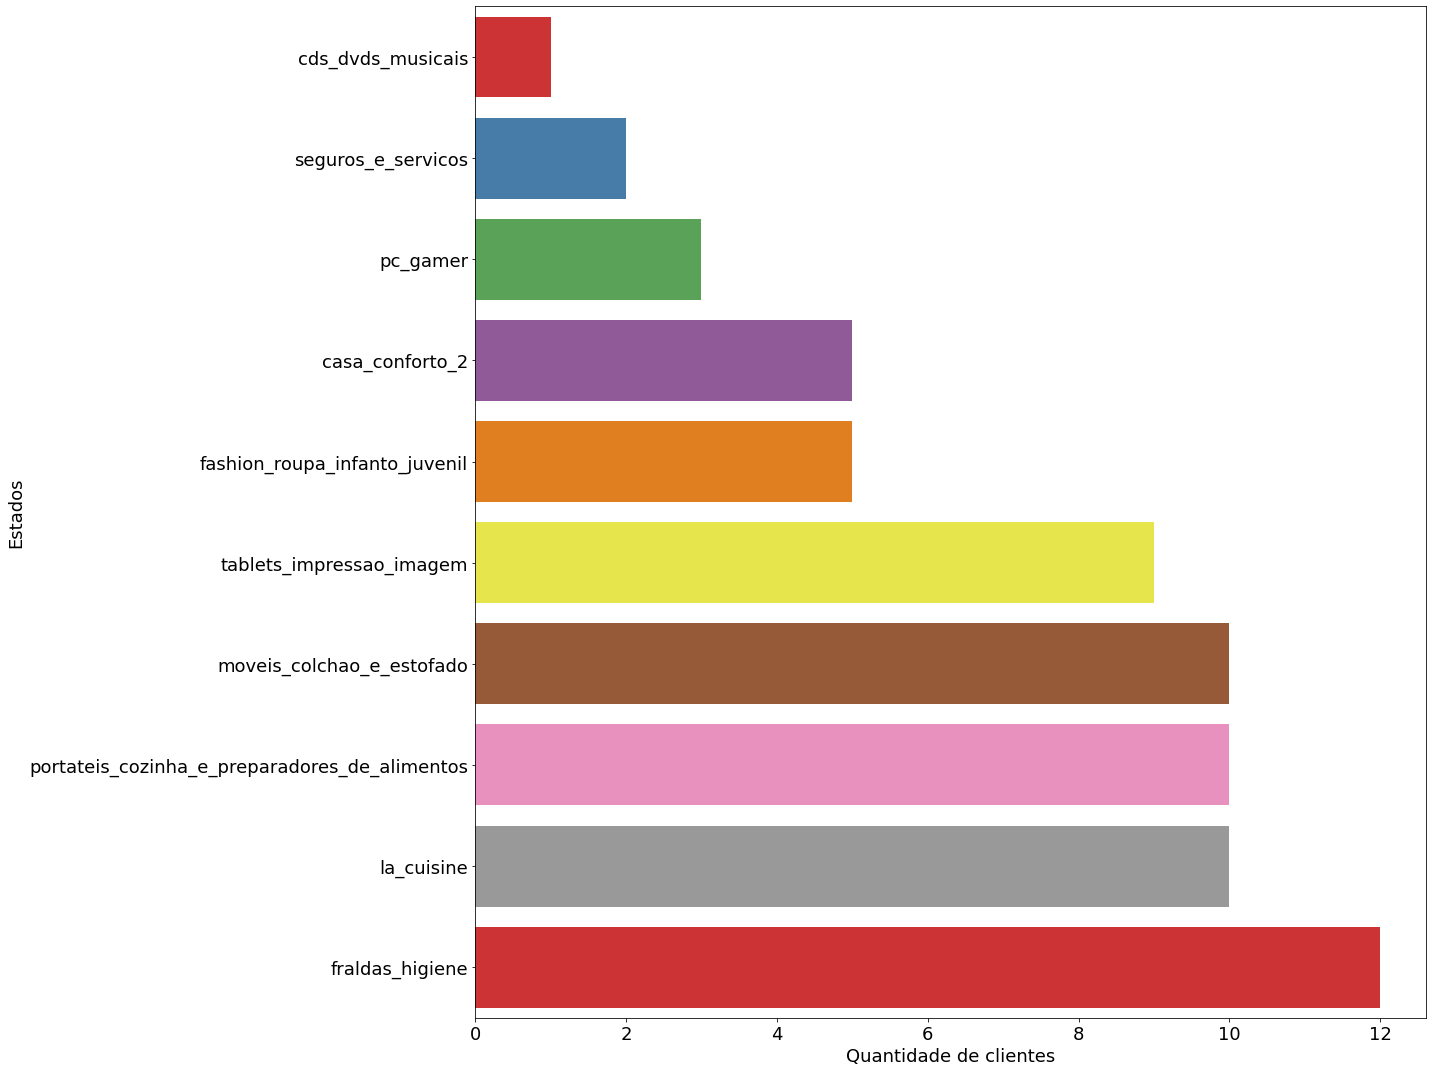

In [24]:
# Agrupando os clientes por estado
produtos = df_products.product_category_name.value_counts().sort_values().head(10)

fig, ax = plt.subplots(figsize=(20,15))

sns.barplot(y=produtos.index, x=produtos.values,ax= ax, palette="Set1")

# Nome e tamanho do label x
ax.set_xlabel('Quantidade de clientes', fontdict={'fontsize':18})

# Nome e tamanho do label y
ax.set_ylabel('Estados', fontdict={'fontsize':18})

#mudando tamanho dos labels dos ticks
ax.tick_params(labelsize=18)

#otimizar espaço da figure
fig.tight_layout();

## Conjunto de dados de vendedores

Este conjunto de dados inclui dados sobre os vendedores que atenderam aos pedidos feitos na Olist. Use-o para encontrar a localização do vendedor e para identificar qual vendedor atendeu a cada produto.

Colunas:
- **seller_id** - identificador único do vendedor
- **seller_zip_code_prefix** - primeiros 5 dígitos do código postal do vendedor
- **seller_city** - nome da cidade do vendedor
- **seller_state** - estado de vendedor

In [25]:
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


## Tradução do nome da categoria

Traduz o nome da categoria do produto para o inglês.

Colunas:
- **product_category_name** - nome da categoria em portugues
- **product_category_name_english** - nome da categoria em inglês

In [26]:
df_product_category.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


# Juntando os Datasets e tratando os dados

In [27]:
# dataset de pedidos e itens
ordersList = pd.merge(df_orders, df_order_items, on='order_id', how='left')
# Merge com os produtos
data = pd.merge(ordersList, df_products, on='product_id', how='outer')
# ordem de pagamentos // está duplicando os valores
# data = pd.merge(data, df_order_payments, on='order_id', how='outer')
# valor total de cada pedido
data = pd.merge(data, df_total_pedido, on='order_id', how='outer')
# Merge com os vendedores
data = pd.merge(data, df_sellers, on='seller_id', how='outer')
# Avaliação dos pedidos
data = pd.merge(data, df_order_reviews, on='order_id', how='outer')
# Merge final com os clientes
data = pd.merge(data, df_customers, on='customer_id', how='outer')
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,data_pedido,year,month,day,dayofweek,hour,year_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_value,seller_zip_code_prefix,seller_city,seller_state,review_creation_date_review_answer_timestamp,review_id,review_score,review_comment_title,review_comment_message,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-02,2017,10,2,0,10,2017-10,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,38.71,9350.0,maua,SP,2017-10-11 00:00:00 2017-10-12 03:43:48,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,2017-08-15,2017,8,15,1,18,2017-08,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,37.77,9350.0,maua,SP,2017-08-19 00:00:00 2017-08-20 15:16:36,b46f1e34512b0f4c74a72398b03ca788,4.0,NaN,Deveriam embalar melhor o produto. A caixa vei...,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,2017-08-02,2017,8,2,2,18,2017-08,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,37.77,9350.0,maua,SP,2017-08-08 00:00:00 2017-08-08 23:26:23,dc90f19c2806f1abba9e72ad3c350073,5.0,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13,2017-10-23,2017,10,23,0,23,2017-10,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,44.09,9350.0,maua,SP,2017-11-08 00:00:00 2017-11-10 19:52:38,1bafb430e498b939f258b9c9dbdff9b1,3.0,NaN,NaN,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,delivered,2017-08-10 13:35:55,2017-08-10 13:50:09,2017-08-11 13:52:35,2017-08-16 19:03:36,2017-08-23,2017-08-10,2017,8,10,3,13,2017-08,1.0,b00a32a0b42fd65efb58a5822009f629,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-16 13:50:09,75.90,7.79,bebes,58.0,398.0,3.0,238.0,20.0,10.0,15.0,83.69,9350.0,maua,SP,2017-08-17 00:00:00 2017-08-21 12:43:27,b8238c6515192f8129081e17dc57d169,5.0,NaN,"custo beneficio, simples de usar e rápido",02c9e0c05a817d4562ec0e8c90f29dba,8577,itaquaquecetuba,SP


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114092 entries, 0 to 114091
Data columns (total 42 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   order_id                                      114092 non-null  object        
 1   customer_id                                   114092 non-null  object        
 2   order_status                                  114092 non-null  object        
 3   order_purchase_timestamp                      114092 non-null  datetime64[ns]
 4   order_approved_at                             113930 non-null  datetime64[ns]
 5   order_delivered_carrier_date                  112112 non-null  datetime64[ns]
 6   order_delivered_customer_date                 110839 non-null  datetime64[ns]
 7   order_estimated_delivery_date                 114092 non-null  datetime64[ns]
 8   data_pedido                                   114092 n

In [29]:
data.isnull().sum()

order_id                                             0
customer_id                                          0
order_status                                         0
order_purchase_timestamp                             0
order_approved_at                                  162
order_delivered_carrier_date                      1980
order_delivered_customer_date                     3253
order_estimated_delivery_date                        0
data_pedido                                          0
year                                                 0
month                                                0
day                                                  0
dayofweek                                            0
hour                                                 0
year_month                                           0
order_item_id                                      778
product_id                                         778
seller_id                                          778
shipping_l

In [30]:
# Título e mensagem das avaliaçãoes
data['review_comment_title'] = data['review_comment_title'].fillna("Sem título")
data['review_comment_message'] = data['review_comment_message'].fillna("Sem mensagem")

In [31]:
data.shape

(114092, 42)

In [32]:
# Dropando valores nulos
data = data.dropna()
data.shape

(108460, 42)

In [33]:
data.isnull().sum()

order_id                                        0
customer_id                                     0
order_status                                    0
order_purchase_timestamp                        0
order_approved_at                               0
order_delivered_carrier_date                    0
order_delivered_customer_date                   0
order_estimated_delivery_date                   0
data_pedido                                     0
year                                            0
month                                           0
day                                             0
dayofweek                                       0
hour                                            0
year_month                                      0
order_item_id                                   0
product_id                                      0
seller_id                                       0
shipping_limit_date                             0
price                                           0


# Criação do modelo para prever as vendas futuras

In [34]:
df_agrupado = data.groupby("order_estimated_delivery_date")["payment_value"].sum()

In [35]:
df_agrupado.head

<bound method NDFrame.head of order_estimated_delivery_date
2016-10-27      45.46
2016-11-07      39.09
2016-11-23     245.61
2016-11-24    1881.05
2016-11-25    2163.52
               ...   
2018-10-15     443.95
2018-10-16     234.75
2018-10-17      53.73
2018-10-23      67.14
2018-10-25     870.04
Name: payment_value, Length: 444, dtype: float64>

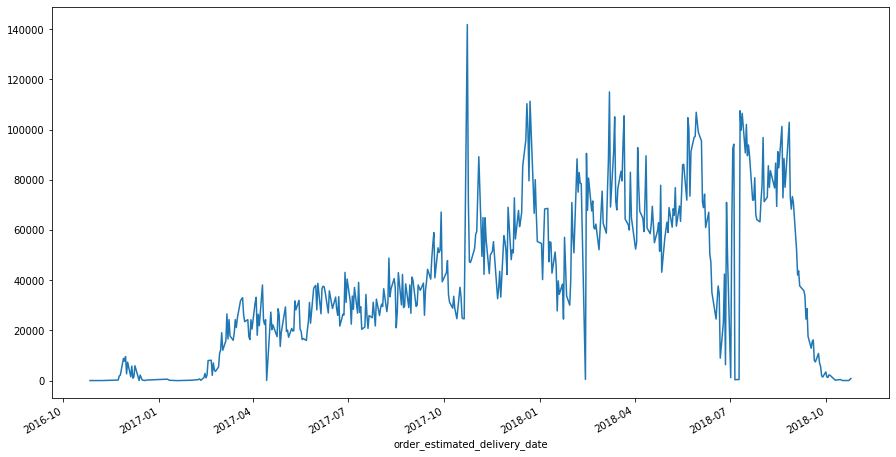

In [36]:
df_agrupado.plot()

In [37]:
#!pip install pmdarima

In [38]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima import auto_arima

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

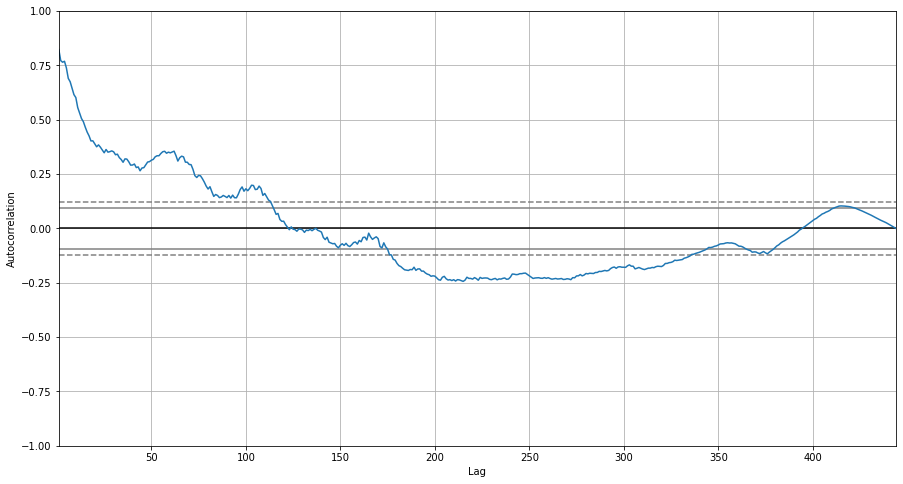

In [39]:
# autocorrelation plot 
autocorrelation_plot(df_agrupado)
pyplot.show()

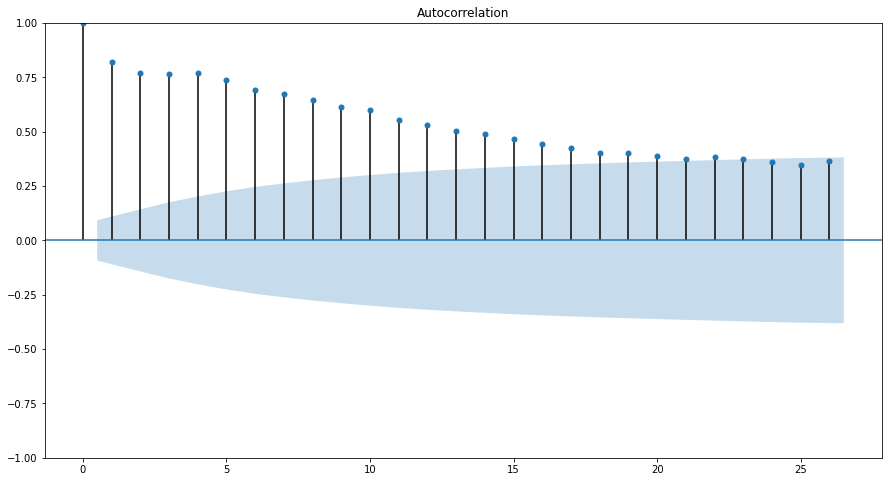

In [40]:
# Correlação parcial = 26 semanas
plot_acf(df_agrupado, lags=26)
pyplot.show()

In [41]:
# Utilizando o auto-arima para encontrar os melhores parametros para p d e q
fit_arima = auto_arima(df_agrupado, d=1, start_p=1, start_q=1, max_p=3,
                      seasonal=True, m=6, D=1, start_P=1, start_Q=1,
                      max_P=2, max_Q=2, information_criterion="aic",
                      trace=True, error_action="ignore", stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=2.70 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=10099.332, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=9916.873, Time=0.57 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=1.78 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=10032.965, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=9885.311, Time=0.44 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=1.46 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=9906.168, Time=0.41 sec
 ARIMA(2,1,0)(2,1,0)[6]             : AIC=9838.153, Time=0.96 sec
 ARIMA(2,1,0)(1,1,0)[6]             : AIC=9865.483, Time=0.68 sec
 ARIMA(2,1,0)(2,1,1)[6]             : AIC=inf, Time=2.12 sec
 ARIMA(2,1,0)(1,1,1)[6]             : AIC=inf, Time=1.23 sec
 ARIMA(3,1,0)(2,1,0)[6]             : AIC=9812.561, Time=1.30 sec
 ARIMA(3,1,0)(1,1,0)[6]             : AIC=9836.628, Time=0.96

In [42]:
# modelo arima para analise de dados - ARIMA(p,d,q)
# p = Quantidade de lags
# d = nível de diferenciaçao
# q = nível de média móvel
model = sm.tsa.arima.ARIMA(df_agrupado, order=(3,1,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [43]:
model_arima = model.fit()

In [44]:
# Exibindo os resultados do treinamento
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:          payment_value   No. Observations:                  444
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -4872.634
Date:                Tue, 01 Feb 2022   AIC                           9753.268
Time:                        22:42:20   BIC                           9769.643
Sample:                             0   HQIC                          9759.726
                                - 444                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5574      0.029    -19.384      0.000      -0.614      -0.501
ar.L2         -0.4253      0.021    -20.031      0.000      -0.467      -0.384
ar.L3         -0.2592      0.030     -8.683      0.0

In [45]:
# Residuais: Erros que aconteceram entre a previsão e o valor real
residuals = pd.DataFrame(model_arima.resid)

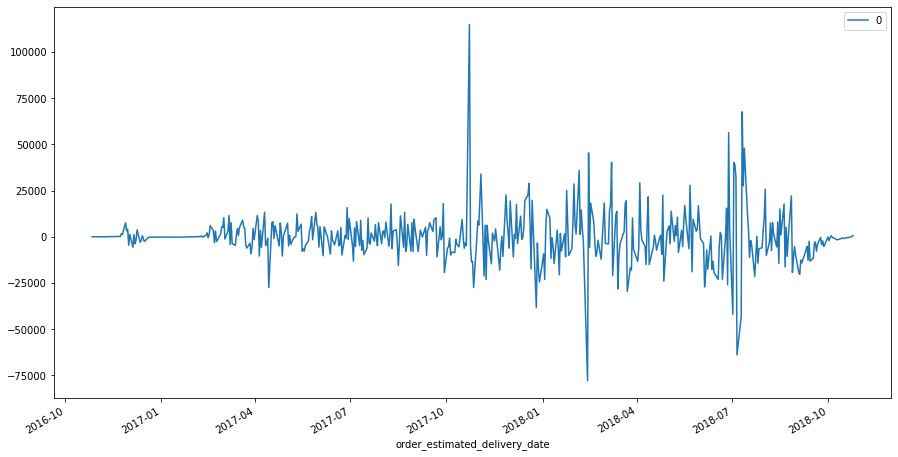

In [46]:
residuals.plot()
pyplot.show()

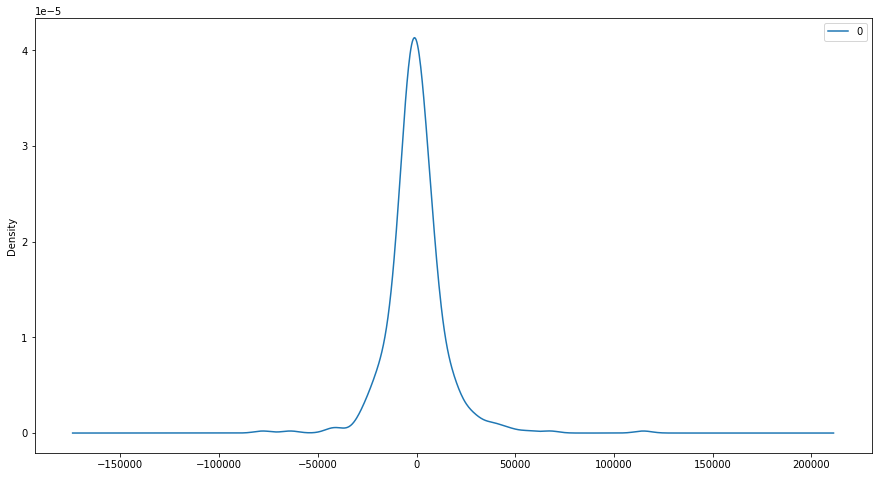

In [47]:
# gráficos de densidade dos residuais para ver a distribuição dos residuais
residuals.plot(kind='kde')
pyplot.show()

In [48]:
# Estatística descritiva dos residuos
print(residuals.describe())

                   0
count     444.000000
mean        2.200875
std     14471.822151
min    -77804.232676
25%     -5934.010827
50%      -482.190636
75%      5330.334340
max    114843.295460


In [49]:
# Separando os dados de treino e teste
X = df_agrupado.values
X = X.astype(float)

In [50]:
# Separando os dados em 50% para treino e 50% para teste
size = int(len(X) * 0.50)

In [51]:
train = X[0:size]
test = X[size:]

In [52]:
# Criando uma variavel history que permite fazer o controle dos dados, treinando e testando com os dados seguintes
history = [x for x in train]

In [53]:
# Lista de predição vazia
predictions = list()

In [54]:
# Função para fazer a diferenciação entre o dado predito e o real
def difference(dataset, interval=1):
    diff = list() 
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# Cria função que reverte o valor diferenciado para o original
def inverse_difference(history, previsao, interval=1):
    return previsao + history[-interval]

In [55]:
# Inicia Walk-Forward para treinar o modelo e testar com a semana seguinte
for t in range(len(test)):
  
    # difference data
    meses_no_ano = 12
    diff = difference(history, meses_no_ano)
    # cria um modelo ARIMA com os dados de history
    model = sm.tsa.arima.ARIMA(diff, order=(1,1,1))
    # treina o modelo ARIMA
    model_fit = model.fit()
    # a variável valor_predito recebe o valor previsto pelo modelo
    valor_predito = model_fit.forecast()[0]
    # valor_predito recebe o valor revertido (escala original)
    valor_predito = inverse_difference(history, valor_predito, meses_no_ano)
    # adiciona o valor predito na lista de predicões
    predictions.append(valor_predito)
    # a variável valor_real recebe o valor real do teste
    valor_real = test[t]
    # adiciona o valor real a variável history
    history.append(valor_real)
    # imprime valor predito e valor real
    print('Valor predito=%.3f, Valor esperado=%3.f' % (valor_predito, valor_real))

Valor predito=50687.651, Valor esperado=36887
Valor predito=76660.041, Valor esperado=43568
Valor predito=23211.942, Valor esperado=33291
Valor predito=46501.829, Valor esperado=57732
Valor predito=29137.724, Valor esperado=55503
Valor predito=71902.875, Valor esperado=51585
Valor predito=51851.235, Valor esperado=42268
Valor predito=38053.070, Valor esperado=69079
Valor predito=62448.284, Valor esperado=48195
Valor predito=52191.656, Valor esperado=52132
Valor predito=57017.953, Valor esperado=50915
Valor predito=32190.062, Valor esperado=72808
Valor predito=52645.117, Valor esperado=56440
Valor predito=56375.327, Valor esperado=67765
Valor predito=50433.201, Valor esperado=61367
Valor predito=78796.123, Valor esperado=63879
Valor predito=68611.598, Valor esperado=66982
Valor predito=65126.727, Valor esperado=85449
Valor predito=64860.214, Valor esperado=95889
Valor predito=103506.496, Valor esperado=110285
Valor predito=82650.592, Valor esperado=100215
Valor predito=93722.652, Valor 

In [56]:
# Avaliando os resultados com os dados de teste
from numpy import sqrt
from sklearn.metrics import mean_squared_error
rmse_arima = sqrt(mean_squared_error(test, predictions))
print(f"RMSE Arima: {rmse_arima:,.3f}")

RMSE Arima: 26,945.932


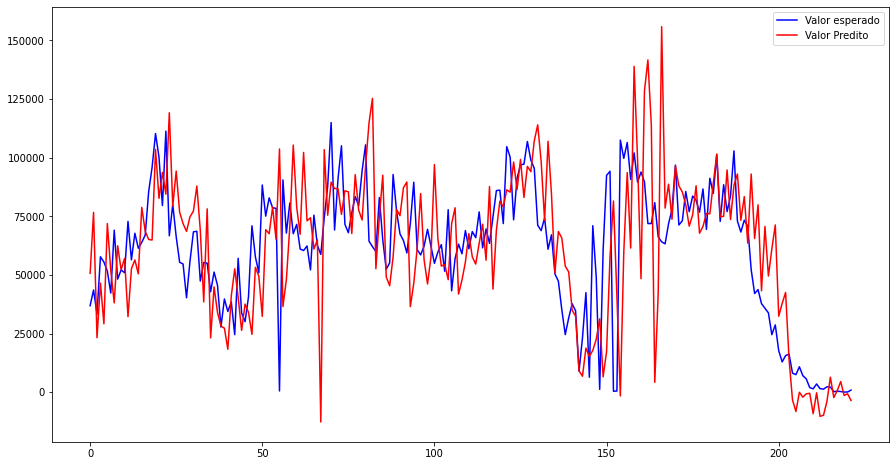

In [57]:
# plot forecasts against actual outcomes 
pyplot.plot(test, color="blue", label="Valor esperado")
pyplot.plot(predictions, color="red", label="Valor Predito")
leg = plt.legend()
pyplot.show()

## Utilizando o XGBoost

In [58]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [59]:
df_agrupado 

order_estimated_delivery_date
2016-10-27      45.46
2016-11-07      39.09
2016-11-23     245.61
2016-11-24    1881.05
2016-11-25    2163.52
               ...   
2018-10-15     443.95
2018-10-16     234.75
2018-10-17      53.73
2018-10-23      67.14
2018-10-25     870.04
Name: payment_value, Length: 444, dtype: float64

In [60]:
df_agrupado = pd.DataFrame(df_agrupado)
df_agrupado

,payment_value
order_estimated_delivery_date,
2016-10-27,45.46
2016-11-07,39.09
2016-11-23,245.61
2016-11-24,1881.05
2016-11-25,2163.52
...,...
2018-10-15,443.95
2018-10-16,234.75
2018-10-17,53.73


In [61]:
train = df_agrupado[0:size]
test = df_agrupado[size:]

In [62]:
# aproveitando a separação de treino e teste que fio realizada anteriormente
train.shape, test.shape

((222, 1), (222, 1))

In [63]:
# Conferindo se houve uma divisão correta
train.index.min(), train.index.max()

(Timestamp('2016-10-27 00:00:00'), Timestamp('2017-11-21 00:00:00'))

In [64]:
test.index.min(), test.index.max()

(Timestamp('2017-11-22 00:00:00'), Timestamp('2018-10-25 00:00:00'))

In [65]:
# Criando uma variavel target com o valor de uma data posterior a atual (trazer o valor de amanhã pra hoje)
train["target"] = train["payment_value"].shift(-1)
train

,payment_value,target
order_estimated_delivery_date,,
2016-10-27,45.46,39.09
2016-11-07,39.09,245.61
2016-11-23,245.61,1881.05
2016-11-24,1881.05,2163.52
2016-11-25,2163.52,8853.39
...,...,...
2017-11-13,42636.94,50007.90
2017-11-14,50007.90,51521.54
2017-11-16,51521.54,55366.59


In [66]:
train = train.dropna()

In [67]:
test["target"] = test["payment_value"].shift(-1)
test

,payment_value,target
order_estimated_delivery_date,,
2017-11-22,36886.91,43567.84
2017-11-23,43567.84,33291.08
2017-11-24,33291.08,57732.14
2017-11-27,57732.14,55502.67
2017-11-28,55502.67,51585.48
...,...,...
2018-10-15,443.95,234.75
2018-10-16,234.75,53.73
2018-10-17,53.73,67.14


In [68]:
test = test.dropna()

In [69]:
x_train = train.loc[:, ["payment_value"]].values
y_train = train.loc[:, ["target"]].values
x_test = test.loc[:, ["payment_value"]].values
y_test = test.loc[:, ["target"]].values

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((221, 1), (221, 1), (221, 1), (221, 1))

Definido os melhores parametros

In [70]:
params = { 'max_depth': [3,6,10], 
           'learning_rate': [0.01, 0.05, 0.1], 
           'n_estimators': [100, 500, 1000], 
           'colsample_bytree': [0.3, 0.7]}

In [71]:
xgbr = XGBRegressor(seed=20)

In [72]:
# Realizando diversos testes para sugerir os melhores parâmetros
clf = GridSearchCV(estimator=xgbr,
                   param_grid=params,
                   scoring="neg_mean_squared_error"
                   )

In [73]:
clf.fit(x_train, y_train)

[22:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(estimator=XGBRegressor(seed=20),
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [74]:
print("Melhores parâmetros:", clf.best_params_) 
print("Menor RMSE: ", (-clf.best_score_)**(1/2.0))

Melhores parâmetros: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Menor RMSE:  19212.137025701522


In [75]:
clf.best_estimator_

XGBRegressor(colsample_bytree=0.3, learning_rate=0.01, seed=20)

In [76]:
model = XGBRegressor(colsample_bytree=0.3,
                     learning_rate= 0.01, 
                     max_depth=3,
                     n_estimators=1000,
                     )
model.fit(x_train, y_train)

[22:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.3, learning_rate=0.01, n_estimators=1000)

In [77]:
predict = model.predict(x_test)

In [78]:
# Score do modelo
model.score(x_test, y_test)

-0.13149507874112554

In [79]:
baseline_rmse = mean_squared_error(predict, y_test, squared=False)
rmse_xgb = sqrt(mean_squared_error(y_test, predict))
print(f"RMSE XGB: {rmse_xgb:,.3f}")

RMSE XGB: 30,192.225


In [80]:
# Criando um dataframe para plotar o resultado
result = pd.DataFrame(y_test)
result = result.rename(columns={0: "y_test"})
result.head()

,y_test
0,43567.84
1,33291.08
2,57732.14
3,55502.67
4,51585.48


In [81]:
# Adicionando as predições ao dataframe
result["predict"] = pd.DataFrame(predict)
result.head()

,y_test,predict
0,43567.84,32547.296875
1,33291.08,40120.492188
2,57732.14,28501.343750
3,55502.67,52959.812500
4,51585.48,40704.566406


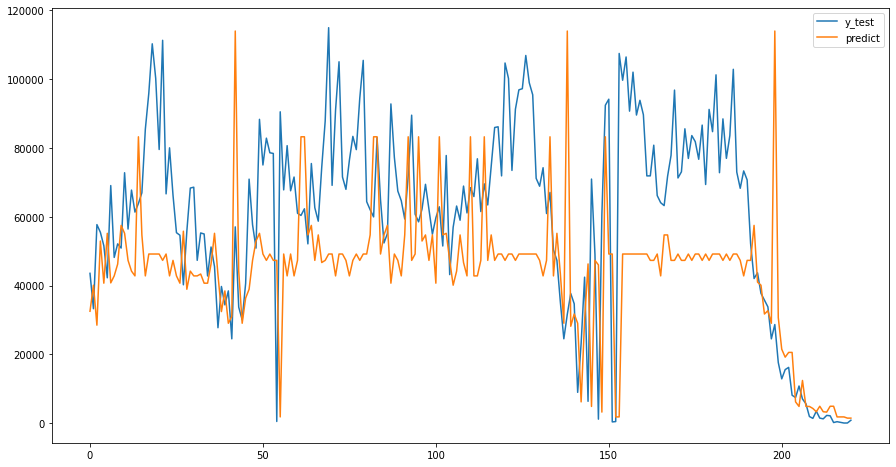

In [82]:
# Plotando a comparação entre o valor predito com o valor real
result.plot()

## Linear Regression

In [83]:
from sklearn.linear_model import LinearRegression

In [84]:
model_lr = LinearRegression()

In [85]:
model_lr.fit(x_train, y_train)

LinearRegression()

In [86]:
model_lr.score(x_test, y_test)

0.46471294091386484

In [87]:
predict_regression = model_lr.predict(x_test)

In [88]:
rmse_lr = mean_squared_error(predict_regression, y_test, squared=False)
rmse_lr

20766.444856180624

In [89]:
# Criando um Dataframe
result_lr = pd.DataFrame(y_test)
result_lr = result_lr.rename(columns={0: "y_test"})
result_lr.head()

,y_test
0,43567.84
1,33291.08
2,57732.14
3,55502.67
4,51585.48


In [90]:
# Adicionando as predições ao dataframe
result_lr["predict_regression"] = pd.DataFrame(predict_regression)
result_lr.head()

,y_test,predict_regression
0,43567.84,34520.601503
1,33291.08,39435.129647
2,57732.14,31875.489560
3,55502.67,49854.465127
4,51585.48,48214.454970


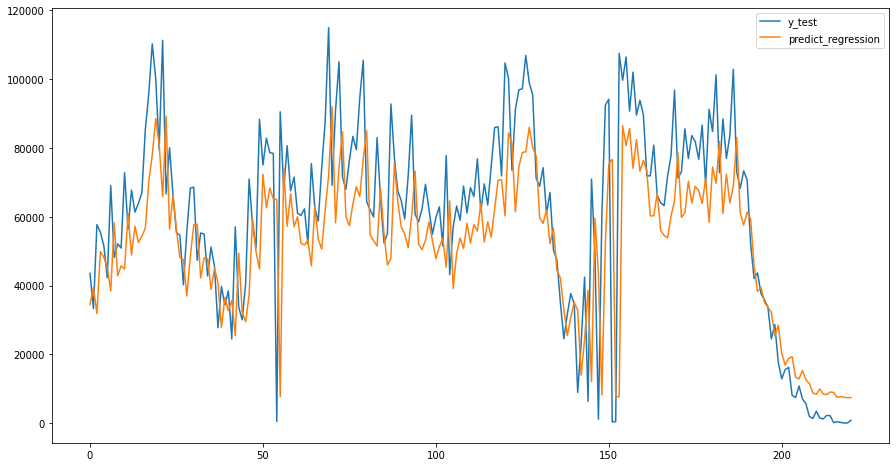

In [91]:
# Plotando a comparação entre o valor predito com o valor real
result_lr.plot()

In [92]:
print(f"RMSE Arima: {rmse_arima}, \nRMSE XGB: {rmse_xgb}, \nRMSE Linear Regression: {rmse_lr}")

RMSE Arima: 26945.931535684533, 
RMSE XGB: 30192.224756433527, 
RMSE Linear Regression: 20766.444856180624


### Conclusão

O modelo que tever melhor desempenho foi o algoritmo de Regressão Linear, com base na métrica utilizada  que foi o RMSE (root mean squared error): é a medida que calcula "a raiz quadrática média" dos erros entre valores observados (reais) e predições (hipóteses). 

Expressa o erro médio do modelo preditivo, em relação aos dados originais (treino e teste), quanto menor, melhor.